# 패키지

In [22]:
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Add, LeakyReLU, BatchNormalization,Activation,GlobalAveragePooling2D,ZeroPadding2D, Convolution2D,concatenate,PReLU,Reshape, Multiply
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

from tensorflow.keras import layers
from tensorflow.keras import models

import datetime
import os, sys, glob
%matplotlib inline

# plt.style.use('dark_background')

# GPU 할당하기

In [39]:
from tensorflow.compat.v1 import ConfigProto,InteractiveSession
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config = config)
print(os.popen('nvidia-smi').read())

/home/centos/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow_core/python/client/session.py:1752: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Wed Aug 19 16:02:11 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:05.0 Off |                  Off |
| N/A   35C    P0    54W / 300W |  17840MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:00:06.0 Off |                  Off |
| N/A   36C    P0    53W / 300W |  17560MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

# 이미지 사이즈 & 모델명 정하기

In [24]:
# df, img 불러오고 model화 시키기 전 전처리과정
img_size = 251
l = 441
model_name = "sj_seresnet101_new"
model_weight = model_name +"_weight.h5"

# DataFrame 만들기

In [25]:
BA = "/home/centos/X-Age_Ver1"

absolute_path = BA+"/03_Modeling/00_roi_final"

path= "../00_roi_final"

file_name = np.array(["{0:03d}_05.jpg".format(i+1) for i in range(l)])

df = pd.read_excel(path+"/BA_Total.xlsx")
imgs = np.array([cv2.imread(path+"/"+file_name[i]) for i in range(l)])
df['boneage'] = df.BA*12
ba_mean = df.boneage.mean()
ba_std = df.boneage.std()
df["BA_z"] = (df.boneage-ba_mean)/ba_std
df.filename = file_name
df["gender"] = df["성별"]%2



In [26]:
# BA = "/home/centos/BA/img_preprocess"

# absolute_path = BA+"/05_02"

# path= "/home/centos/X-Age_Ver1/03_Modeling/00_roi_final"

# file_name = np.array(["{0:03d}_05_02.jpg".format(i+1) for i in range(l)])

# df = pd.read_excel(path+"/BA_Total.xlsx")
# imgs = np.array([cv2.imread(absolute_path+"/"+file_name[i]) for i in range(l)])
# df['boneage'] = df.BA*12
# ba_mean = df.boneage.mean()
# ba_std = df.boneage.std()
# df["BA_z"] = (df.boneage-ba_mean)/ba_std
# df.filename = file_name
# df["gender"] = df["성별"]%2

# 젠더와 나이 나누기

In [27]:
def multi_generator(df):
    gender_in = np.array(df.gender)
    img_in = []
    age = np.array(df.BA_z)
    
    for file_path in df.filename:
        img = cv2.imread(path+'/'+file_path)
        small = cv2.resize(img, (img_size,img_size),cv2.INTER_AREA)
        img_in.append(small)
        
    img_in = np.array(img_in)
        
    
    return [gender_in,img_in],age

In [28]:
# def multi_generator(df):
#     gender_in = np.array(df.gender)
#     img_in = []
#     age = np.array(df.BA_z)
    
#     for file_path in df.filename:
#         img = cv2.imread(absolute_path+'/'+file_path)
#         small = cv2.resize(img, (img_size,img_size),cv2.INTER_AREA)
#         img_in.append(small)
        
#     img_in = np.array(img_in)
        
    
#     return [gender_in,img_in],age

# process 시각화 및 손실함수

In [29]:
# process시각화 및 손실함수

def plot_it(history):
    plt.style.use('default')
    '''function to plot training and validation error'''
    fig, ax = plt.subplots( figsize=(20,10))
    ax.plot(history.history['mae_in_months'])
    ax.plot(history.history['val_mae_in_months'])
    plt.title('Model Error')
    plt.ylabel('error')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    ax.grid(color='black')
    fig = plt.gcf()
    fig.savefig("../04_model_visualization/"+model_name+".jpg", dpi=fig.dpi)
    
from tensorflow.keras.metrics import mean_absolute_error

def mae_in_months(x_p, y_p):
    '''function to return mae in months'''
    return mean_absolute_error((ba_std*x_p + ba_mean), (ba_std*y_p + ba_mean)) 

# train_val_set 만들기

In [30]:
new_df = df.drop([218,425])
new_df = new_df.reset_index(drop=True)


from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(new_df, test_size = 0.2, random_state = 0)

train_X,train_y = multi_generator(train_df)
val_X, val_y = multi_generator(val_df)

# 모델링

# se-resnet

In [31]:
import sys
sys.path.insert(0,'/home/centos/X-Age_Ver1/03_Modeling/01_model_module')

In [32]:
import CNN_model_module
model = CNN_model_module.se_resnet(dense_activation='tanh')

In [32]:
model.save("../03_model_result/"+model_name+".h5")

In [33]:
model.compile(optimizer='adam', loss='mse',metrics=[mae_in_months])

In [34]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 251, 251, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 257, 257, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_104 (Conv2D)             (None, 126, 126, 64) 9472        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
batch_normalization_166 (BatchN (None, 126, 126, 64) 256         conv2d_104[0][0]                 
____________________________________________________________________________________________

Train on 351 samples, validate on 88 samples
Epoch 1/1000
351/351 [==============================] - 6s 17ms/sample - loss: 0.0091 - mae_in_months: 1.4016 - val_loss: 0.4284 - val_mae_in_months: 9.9469
Epoch 2/1000
351/351 [==============================] - 7s 19ms/sample - loss: 0.0082 - mae_in_months: 1.3117 - val_loss: 0.4174 - val_mae_in_months: 9.6629
Epoch 3/1000
351/351 [==============================] - 4s 10ms/sample - loss: 0.0181 - mae_in_months: 1.7873 - val_loss: 0.4456 - val_mae_in_months: 10.0429
Epoch 4/1000
351/351 [==============================] - 14s 39ms/sample - loss: 0.0125 - mae_in_months: 1.5401 - val_loss: 0.3850 - val_mae_in_months: 9.4761
Epoch 5/1000
351/351 [==============================] - 8s 22ms/sample - loss: 0.0136 - mae_in_months: 1.6707 - val_loss: 0.3193 - val_mae_in_months: 8.5024
Epoch 6/1000
351/351 [==============================] - 8s 22ms/sample - loss: 0.0097 - mae_in_months: 1.3952 - val_loss: 0.2711 - val_mae_in_months: 7.8099
Epoch 7/100

351/351 [==============================] - 3s 10ms/sample - loss: 0.0093 - mae_in_months: 1.3809 - val_loss: 0.2622 - val_mae_in_months: 7.4849
Epoch 53/1000
351/351 [==============================] - 3s 10ms/sample - loss: 0.0087 - mae_in_months: 1.1797 - val_loss: 0.2451 - val_mae_in_months: 7.1618
Epoch 54/1000
351/351 [==============================] - 3s 10ms/sample - loss: 0.0084 - mae_in_months: 1.2402 - val_loss: 0.2509 - val_mae_in_months: 7.2205
Epoch 55/1000
351/351 [==============================] - 3s 10ms/sample - loss: 0.0106 - mae_in_months: 1.3389 - val_loss: 0.2672 - val_mae_in_months: 7.5240
Epoch 56/1000
351/351 [==============================] - 3s 10ms/sample - loss: 0.0088 - mae_in_months: 1.2444 - val_loss: 0.2390 - val_mae_in_months: 7.1047
Epoch 57/1000
351/351 [==============================] - 3s 10ms/sample - loss: 0.0058 - mae_in_months: 1.0605 - val_loss: 0.2437 - val_mae_in_months: 7.2785
Epoch 58/1000
351/351 [==============================] - 3s 10ms/s

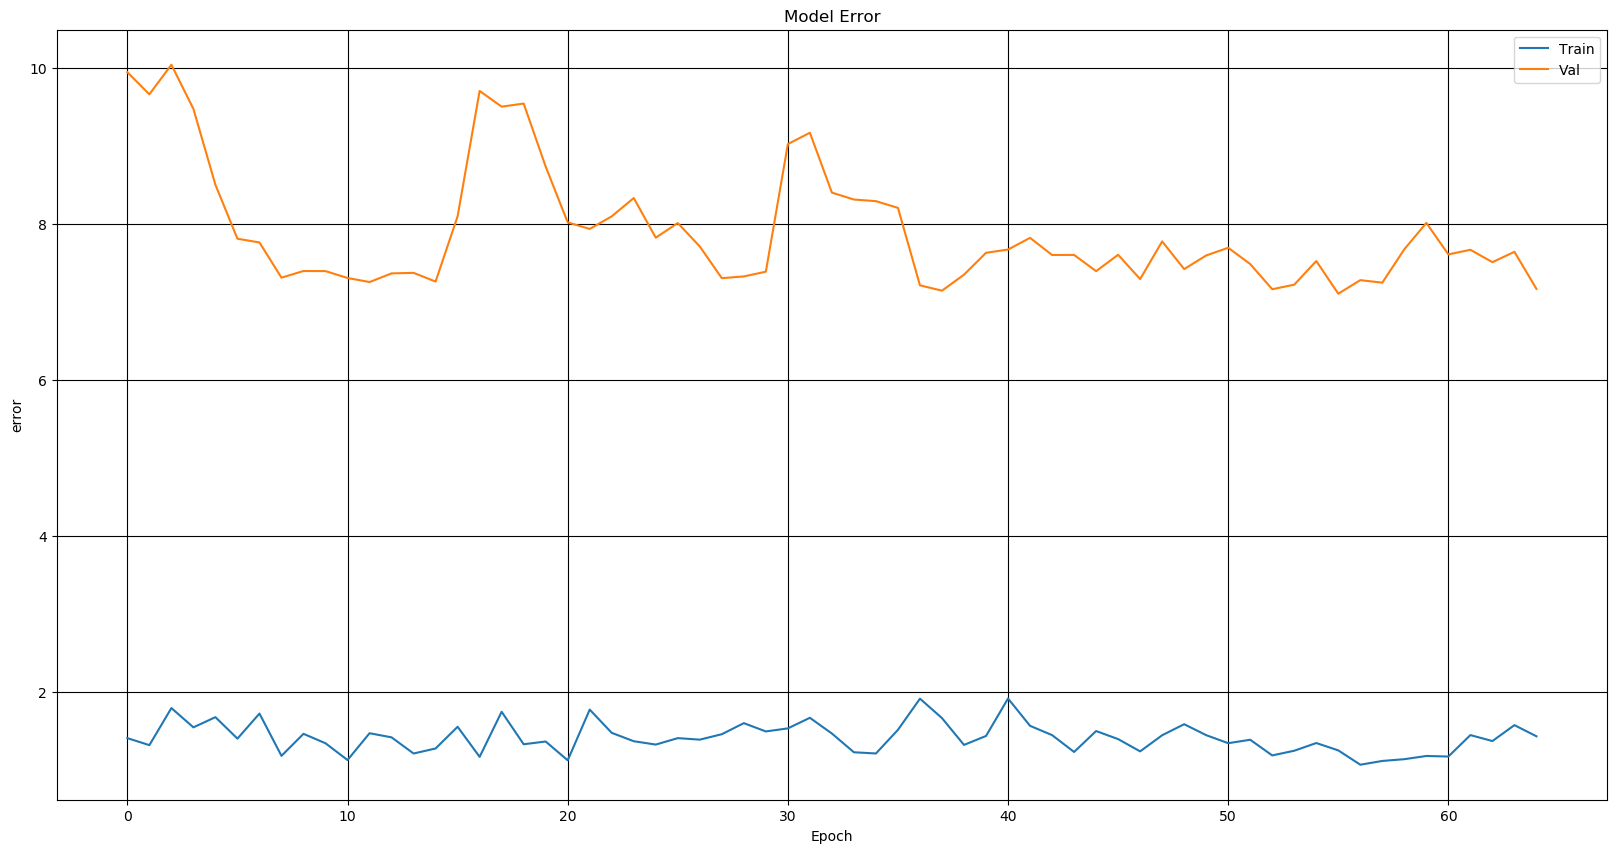

In [41]:
# 모델 fit
from tensorflow.keras.callbacks import *
epochs = 1000
#early stopping
early_stopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience= 50,
                              verbose=0, mode='auto')

mc = ModelCheckpoint("../03_model_result/"+model_weight, monitor='val_loss', mode='min', save_best_only=True)
rLR = ReduceLROnPlateau(
    monitor='val_loss',  # 검증 손실을 기준으로 callback이 호출됩니다
    factor=0.5,          # callback 호출시 학습률을 1/2로 줄입니다
    patience=50,         # epoch 10 동안 개선되지 않으면 callback이 호출됩니다
)

callbacks = [early_stopping,mc,rLR]


#fit model
history = model.fit(train_X,train_y,
                    validation_data = (val_X,val_y),
                    epochs = epochs,
                    callbacks= callbacks)
plot_it(history)

In [43]:
model.load_weights("../03_model_result/"+model_weight)

In [44]:
pred = model.predict(val_X)*ba_std+ba_mean
mse, mae = model.evaluate(val_X,val_y)

from sklearn.metrics import r2_score
r2 = r2_score(val_df.boneage,pred)
print(f"mae_year : {mae/12}, rmse : {mse/12},  r2_score : {r2}" )

88/88 [==============================] - 0s 3ms/sample - loss: 0.2325 - mae_in_months: 7.2607
mae_year : 0.6050548950831095, rmse : 0.019373242150653492,  r2_score : 0.7964807229901787


In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
v = val_y*ba_std+ba_mean
mean_absolute_error(v,np.round(pred))/12, mean_squared_error(v,pred)/12

(0.5496212121212122, 5.51672414096721)

In [23]:
r2_score(v,pred)

0.8519983353243157

In [33]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [50]:
# result_df = pd.DataFrame(columns=['model','mae','mse','r2_score','roi','class'])
# result_df.to_csv("result.csv",encoding='utf-8',index=False)
result_df = pd.read_csv("result.csv")
result_df.loc[len(result_df)]=(model_weight,mae/12,mse/12,r2,True,False)
result_df.to_csv("result.csv",index=False)
result_df

,model,mae,mse,r2_score,roi,class
0,se_resNET101_SJ+gender_test_weight.h5,0.451184,0.024622,0.875888,True,False
1,VGG+gender_weight.h5,0.440176,0.012492,0.880929,True,False
2,VGG16X2+gender_weight.h5,0.462613,0.012151,0.884177,True,False
3,real_se_resNET101_SJ1+gender_weight.h5,0.434768,0.023726,0.885507,True,False
4,real_se_resNET101_SJ2+gender_weight.h5,0.426653,0.023283,0.889387,True,False


In [5]:
## 전체 비교 코드

model.load_weights('../03_model_result/real_se_resNET101_SJ2+gender_weight.h5')

new_X,new_y=multi_generator(new_df)

pred = model.predict(new_X)*ba_std+ba_mean
new = new_y*ba_std+ba_mean
mean_absolute_error(new,np.round(pred))/12,mean_squared_error(new,np.round(pred))/12

NameError: name 'model' is not defined

In [ ]:
pred = model.predict(generator(df,model,2))*ba_std+ba_mean
month = np.array(df.boneage)
pred_all = pred.reshape(-1)

In [ ]:
fig, ax1 = plt.subplots(1,1, figsize = (6,6))
ax1.plot(month, pred_all, 'r.', label = 'predictions')
ax1.plot(month, month, 'b-', label = 'actual')
ax1.legend()
ax1.set_xlabel('Actual Age (Months)')
ax1.set_ylabel('Predicted Age (Months)')